# Scaling laws calculations pipeline
- Filter out dendritic skeleton before plotting
- Visualize goodness of fit for alpha for different branch points 
- Get statistics for Apical vs Basal Dendrites separately

In [1]:
# connectomics imports
import platform
import os

platstring = platform.platform()
if ('Darwin' in platstring) or ('macOS' in platstring):
    # macOS 
    data_root = "/Volumes/Brain2022/em-connectomics"
elif 'Windows'  in platstring:
    # Windows (replace with the drive letter of USB drive)
    data_root = "E:/em-connectomics"
elif ('amzn' in platstring):
    # then on AWS
    data_root = "/data/em-connectomics-data/"
else:
    # then your own linux platform
    # EDIT location where you mounted hard drive
    data_root = "/media/$USERNAME/Brain2022/em-connectomics"
    
# OR if you'd like to override the auto options
# data_root = "./proofread_skeletons/"

In [2]:
# this is the EM specific package for querying the EM data
from caveclient import CAVEclient


In [3]:
# import some of our favorite packages
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import scipy as sc
%matplotlib widget

In [4]:
# if this errors, go to the CAVEsetup notebook
datastack_name = 'minnie65_public_v343'
client = CAVEclient(datastack_name)

In [5]:
coreg_df = pd.read_feather('coreg_all_good_scans_dsi_osi.feather')

In [6]:
highOSIdf = coreg_df[(coreg_df.OSI >= 0.6) & (coreg_df.Act_Pref_Or >= 20)]
highOSIdf = highOSIdf.sort_values(by=['OSI'],ascending=False)

In [7]:
# query the proofreading info of the cells with extended dendritic proofreading
# DO THIS TO GET MORE CELLS TO ANALYZE
clean_neuron_df = client.materialize.query_table('proofreading_status_public_release',
                                              filter_in_dict={'status_axon':['extended', "clean"],
                                                              "status_dendrite": ["clean", "extended"]})

In [9]:
lowOSIdf = coreg_df[(coreg_df.OSI <= 0.07) & (coreg_df.Act_Pref_Dir >= 20) & (np.vstack(coreg_df.pt_position.values)[:,0]/1000 < 1000)]
lowOSIdf = lowOSIdf.sort_values(by=['OSI'])

In [11]:
neuron_id  = clean_neuron_df.iloc[0].pt_root_id

In [12]:
# query soma df to get id for mesh file
neuron_soma_df = client.materialize.query_table('aibs_soma_nuc_metamodel_preds_v117')

In [13]:
neuron_soma_df.columns

Index(['id', 'valid', 'target_id', 'classification_system', 'cell_type',
       'id_ref', 'valid__ref', 'volume', 'pt_supervoxel_id', 'pt_root_id',
       'pt_position', 'bb_start_position', 'bb_end_position'],
      dtype='object')

In [14]:
# import neuron as skeleton - check how many morphological properties can be applied
from meshparty import meshwork

# the files are named according to the segid and the nucleus_id of each cell
# this is to keep things straight for us as there are often many versions of 
# the same nucleus during proofreading. 
# so lets look up the nuc_id of our neuron

nuc_id=neuron_soma_df.query(f'pt_root_id=={neuron_id}').target_id.values[0]
nuc_type = neuron_soma_df.query(f'pt_root_id=={neuron_id}').cell_type.values[0]
mesh_filename = f"{neuron_id}_{nuc_id}.h5"
nrn = meshwork.load_meshwork(os.path.join(data_root,mesh_filename))

In [15]:
mesh_filename

'864691135182092034_303216.h5'

In [16]:
nuc_type

'5P-ET'

In [19]:
# avoid segment map - workflow:
# test
upstream_radii = []
upstream_info = []
downstream_info = []
downstream_radii = []
upstream_area_factor = []
downstream_area_factor = []

Ncells = 1
for i in range(Ncells):
    print(i)
    # filter branch points by those in dendrite
    #neuron_id = highOSIdf.iloc[i].pt_root_id
    if (len(neuron_soma_df.query(f'pt_root_id=={neuron_id}').target_id.values) == 0):
        continue
    nuc_id=neuron_soma_df.query(f'pt_root_id=={neuron_id}').target_id.values[0]
    nuc_type = neuron_soma_df.query(f'pt_root_id=={neuron_id}').cell_type.values[0]
    mesh_filename = f"{neuron_id}_{nuc_id}.h5"
    if not (os.path.exists(os.path.join(data_root,mesh_filename))):
        continue
    nrn = meshwork.load_meshwork(os.path.join(data_root,mesh_filename))
    apical_dendrite_mesh = nrn.anno.apical_mesh_labels.mesh_index
    apical_dendrite_skel = nrn.anno.apical_mesh_labels.skel_index
    dendrite_branch_points = nrn.skeleton.SkeletonIndex(list(set(np.array(nrn.skeleton.branch_points)).intersection(np.array(apical_dendrite_skel))))
    branch_children=nrn.skeleton.child_nodes(dendrite_branch_points)
    branch_parents=nrn.skeleton.parent_nodes(dendrite_branch_points)
    for par in branch_parents.to_mesh_region:
        seg=nrn.anno.segment_properties.filter_query(par.to_mesh_mask).df
        #seg.drop_duplicates(subset = ["area"])
        upstream_info.append(seg)
        upstream_radii.append(seg.r_eff.unique())
        #upstream_radii.append(seg.area.unique())
        upstream_area_factor.append(seg.area_factor.unique())
    for child in branch_children:
        seg=nrn.anno.segment_properties.filter_query(child.to_mesh_mask).df
        #seg.drop_duplicates(subset = ["area"])
        downstream_info.append(seg)
        downstream_radii.append(seg.r_eff.unique())
        #downstream_radii.append(seg.area.unique())
        downstream_area_factor.append(seg.area_factor.unique())

0


OMP: Info #277: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [20]:
upstream_filt = []
upstream_inds = []
upstream_filt = [x for i,x in enumerate(upstream_radii) if x]
upstream_inds = [i for i,x in enumerate(upstream_radii) if x]

In [21]:
# create sq sum array of downstream radii

def getSumDS(upstream_filt,downstream_radii,a):
    sumds = np.zeros((len(upstream_filt),1))
    inds = 0
    for i in range(len(upstream_radii)):
        if (i in upstream_inds):
            sumds[inds] = np.sum((np.array(downstream_radii[inds])/1000)**a)
            inds = inds+1
    return sumds

In [22]:
len(upstream_filt)


47

In [23]:
# fitting alpha - visualize wrt strahler number - does your goodness of fit for an alpha vary in space? 
# Can also plot as a function of strahler number


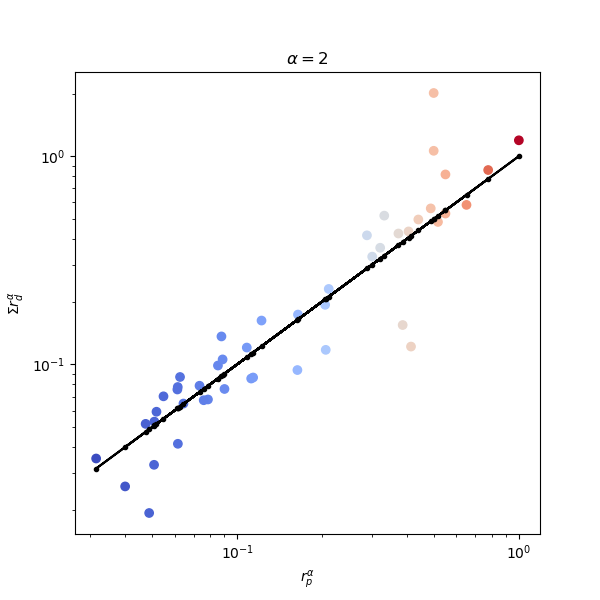

In [24]:
# scatter upstream and downstream radii ^2 etc
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)
a = 2
sumds = getSumDS(upstream_filt,downstream_radii,a)
maxUS = np.max((np.array(upstream_filt)/1000)**a)
ax.scatter((np.array(upstream_filt)/1000)**a/maxUS, sumds/maxUS,c=np.array(upstream_filt)/1000,cmap='coolwarm')
ax.plot((np.array(upstream_filt)/1000)**a/maxUS, (np.array(upstream_filt)/1000)**a/maxUS, 'k.-')
ax.set_ylabel(r'$\Sigma r_d^{\alpha}$')
ax.set_xlabel(r'$r_p^{\alpha}$')
ax.set_title(r'$\alpha =$' + str(a))
ax.set_yscale('log')
ax.set_xscale('log')
#plt.coolwarm()
#ax.scatter(np.array(upstream_radii)/1000, sumds)

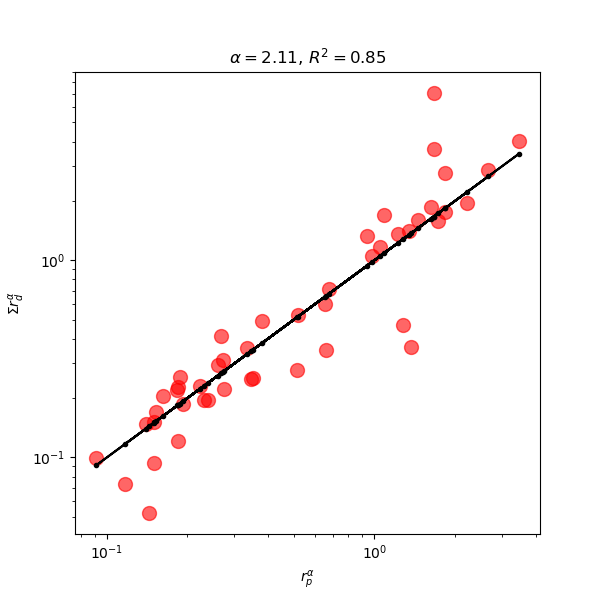

In [27]:
# get best fit alpha for full or part of the dendritic tree

import operator

alist = np.linspace(1,4,20)
r2val = np.zeros_like(alist)

for aind,a in enumerate(alist):
    sumds = getSumDS(upstream_filt,downstream_radii,a)
    #print(a)
    # Calculate r2 score 
    x_in = np.log(np.squeeze((np.array(upstream_filt)/1000)**a))
    y_in = np.log(np.squeeze(sumds))
    
    #x_in = np.squeeze((np.array(upstream_filt)/1000)**a)
    #y_in = np.squeeze(sumds)
    
    L1 = sorted(zip(x_in,y_in), key=operator.itemgetter(0))
    x, y = zip(*L1)
    x = np.asarray(x)
    y = np.asarray(y)
    SStot = np.sum((y - np.mean(y))**2)
    SSres = np.sum((y- x)**2)

    r2val[aind] = 1-(SSres/SStot)

r2val_set = np.max(r2val)
aset = alist[np.argmax(r2val)]

# plot the selected alpha value
sumds_plot = getSumDS(upstream_filt,downstream_radii,aset)
f,ax = plt.subplots(figsize = (6,6))
ax.scatter((np.array(upstream_filt)/1000)**aset,sumds_plot,s=100,c='red',label='Data',alpha=0.6)
ax.plot((np.array(upstream_filt)/1000)**aset, (np.array(upstream_filt)/1000)**aset, 'k.-')

ax.set_ylabel(r'$\Sigma r_d^{\alpha}$')
ax.set_xlabel(r'$r_p^{\alpha}$')
ax.set_title(r'$\alpha =$' + str(np.round(aset,2)) + r', $R^2 =$' + str(np.round(r2val_set,2)))
ax.set_yscale('log')
ax.set_xscale('log')
#ax.set_xlim([0.005,10])
#ax.set_ylim([0.002,10])

In [105]:
# Do apical and basal dendrites have differential morphologies because of a spread in inputs? 


In [149]:
# Differential scaling laws in angular regions? 
# extract parts of skeleton that are in the angular region vs not
# check whether area factors are differentially distributed for basal and apical dendrites separately

# transform coordinates
# get coordinates of skeleton wrt the soma 
# import functions 
from angularUtils import *
apical_vertices = nrn.skeleton.vertices[nrn.anno.apical_mesh_labels.skel_mask]
basal_vertices = nrn.skeleton.vertices[nrn.anno.basal_mesh_labels.skel_mask]
nrn_somapos = nrn.skeleton.vertices[nrn.skeleton.root]
apical_pos_wrtsoma = apical_vertices - nrn_somapos
basal_pos_wrtsoma = basal_vertices - nrn_somapos
apical_pos_radial, majorAxis, apical_pos_transformed, apical_pos_radial_transformed = getRadialCoord(apical_vertices, nrn_somapos)
basal_pos_radial, majorAxis, basal_pos_transformed, basal_pos_radial_transformed = getRadialCoord(basal_vertices, nrn_somapos)

angularRatio_basal, withinAngle, basal_in_range_mask = getAngularDensity(nrn,basal_pos_radial_transformed,nrn.anno.segment_properties.df,'len',angle=np.pi/2)
angularRatio_apical, withinAngle, apical_in_range_mask = getAngularDensity(nrn,apical_pos_radial_transformed,nrn.anno.segment_properties.df,'len',angle=np.pi/2)

In [150]:
angularRatio_apical

0.5147194635650768

In [151]:
basalInRangeMask = nrn.skeleton.SkeletonIndex(np.where(basal_in_range_mask)).to_mesh_mask
basalMask = nrn.anno.basal_mesh_labels.mesh_mask

apicalInRangeMask = nrn.skeleton.SkeletonIndex(np.where(apical_in_range_mask)).to_mesh_mask
apicalMask = nrn.anno.apical_mesh_labels.mesh_mask


In [152]:
np.squeeze(np.array(np.where(apical_in_range_mask))).shape

(1285,)

In [153]:
np.array(apical_dendrite_skel).shape

(2434,)

In [212]:
# avoid segment map - workflow:
# test
upstream_radii = []
upstream_info = []
downstream_info = []
downstream_radii = []
upstream_area_factor = []
downstream_area_factor = []
bp_angle = []

# filter branch points by those in dendrite
dendrite_branch_points = nrn.skeleton.SkeletonIndex(list(set(np.array(nrn.skeleton.branch_points)).intersection(np.array(basal_dendrite_skel))))
#dendrite_branch_points = nrn.skeleton.SkeletonIndex(list(set(np.array(nrn.skeleton.branch_points)).intersection(np.squeeze(np.array(np.where(basal_in_range_mask))))))
branch_children=nrn.skeleton.child_nodes(dendrite_branch_points)
branch_parents=nrn.skeleton.parent_nodes(dendrite_branch_points)
for par in branch_parents.to_mesh_region:
    seg=nrn.anno.segment_properties.filter_query(par.to_mesh_mask).df
    #seg.drop_duplicates(subset = ["area"])
    upstream_info.append(seg)
    upstream_radii.append(seg.r_eff.unique())
    #upstream_radii.append(seg.area.unique())
    upstream_area_factor.append(seg.area_factor.unique())
for child in branch_children:
    seg=nrn.anno.segment_properties.filter_query(child.to_mesh_mask).df
    #seg.drop_duplicates(subset = ["area"])
    downstream_info.append(seg)
    downstream_radii.append(seg.r_eff.unique())
    #downstream_radii.append(seg.area.unique())
    downstream_area_factor.append(seg.area_factor.unique())
    
ptpos = nrn.skeleton.vertices[dendrite_branch_points]
_,_,_, pos_radial_transformed = getRadialCoord(ptpos, nrn_somapos)
angular_dev_fromxaxis = np.abs(np.pi/2 - np.abs(pos_radial_transformed[:,1]))


In [213]:
upstream_filt = []
upstream_inds = []
upstream_filt = [x for i,x in enumerate(upstream_radii) if x]
upstream_inds = [i for i,x in enumerate(upstream_radii) if x]

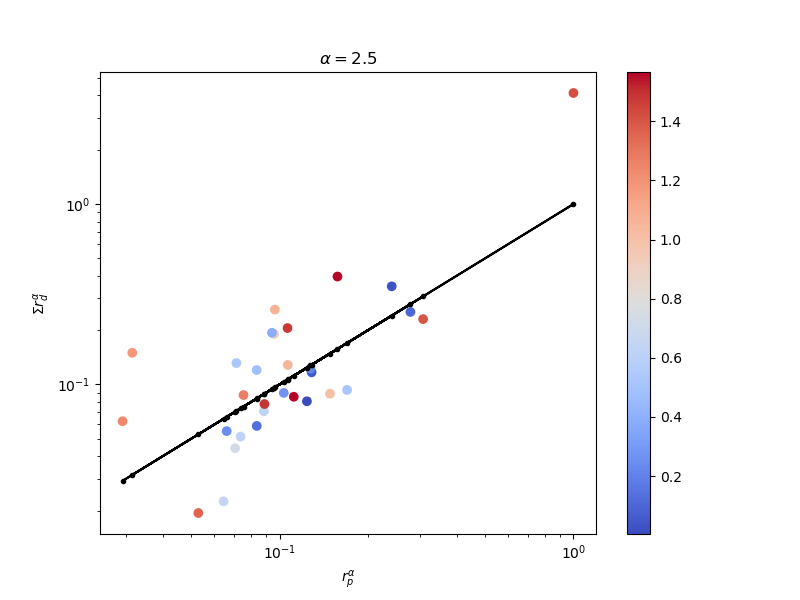

In [215]:
# looking at just basal part - color pts by whether they are inside angular region vs not
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1,1,1)
a = 2.5
sumds = getSumDS(upstream_filt,downstream_radii,a)
maxUS = np.max((np.array(upstream_filt)/1000)**a)
pos_radial_norm = pos_radial_transformed

scatterplot = ax.scatter((np.array(upstream_filt)/1000)**a/maxUS, sumds/maxUS,c=angular_dev_fromxaxis,cmap='coolwarm')
ax.plot((np.array(upstream_filt)/1000)**a/maxUS, (np.array(upstream_filt)/1000)**a/maxUS, 'k.-')
ax.set_ylabel(r'$\Sigma r_d^{\alpha}$')
ax.set_xlabel(r'$r_p^{\alpha}$')
ax.set_title(r'$\alpha =$' + str(a))
ax.set_yscale('log')
ax.set_xscale('log')
plt.colorbar(scatterplot)

#cbar = plt.colorbar()


In [216]:
# Question - how to account for area factor while looking at area scaling? 
# normalize by area factor and plot? 



In [18]:
# Other morphology questions:
# get 0th level axis and get +/- 45 degree slices 
# - Sum over lengths of segments in a given +/- 45deg area along the axis of highest variation 
# - length over branching pts and length/syn density for these areas
